# Lecture 4: Supervised Models, [OLS](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

* How to train an OLS model with `sklearn`.
* How to use an OLS model for prediction and how to evaluate it in test data.

## Imports

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

## Data

To practice fitting models we need data. We can use real data, but for practice it is often better to use specifically generated data that has exactly the shape that we want to practice with.

Whenever we want to generate data, we need to go through NumPy's `ndarray`s. Pandas itself does not afford any APIs to generate data.

We have two options:

1. `sklearn` provides several [methods](https://scikit-learn.org/stable/modules/classes.html#samples-generator) to generate data (e.g., [`make_regression()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html)). I recommend these if you want to practice by yourself and if the custom generator below is too complex. You can use it like this:

In [2]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=100, n_features=1, n_informative=1)

* `n_samples`: 100 observations
* `n_features`: 1 variable
* `n_informative`: 1 variable in the *data-generating process*

Both `X` and `y` are `ndarray`s:

In [3]:
X

array([[ 9.17594628e-01],
       [ 5.52990204e-01],
       [ 1.61793700e+00],
       [-2.66209764e-01],
       [ 3.13884148e-01],
       [-2.24784750e+00],
       [ 2.45596080e+00],
       [-1.78359966e-02],
       [-8.74277634e-01],
       [ 9.05912635e-01],
       [ 1.48016757e+00],
       [-3.04709547e-01],
       [-3.36980609e-01],
       [ 8.66804218e-01],
       [-1.24377392e+00],
       [-4.81077142e-01],
       [ 1.14183340e+00],
       [ 1.13804030e+00],
       [ 1.10134792e+00],
       [ 2.12012790e+00],
       [-8.17110941e-02],
       [-4.43089871e-01],
       [ 6.97082004e-01],
       [ 4.19623356e-01],
       [-5.18501592e-02],
       [-8.94631684e-01],
       [ 1.37720540e+00],
       [ 1.56278535e-03],
       [ 3.86034906e-01],
       [ 5.96641824e-01],
       [ 1.11709453e-01],
       [-8.48497816e-01],
       [-7.82742907e-01],
       [-8.45692772e-01],
       [-4.27618020e-01],
       [ 3.22071518e-01],
       [ 5.92690671e-01],
       [ 5.13631301e-01],
       [ 8.9

In [4]:
y

array([ 5.91825749e+01,  3.56664950e+01,  1.04352919e+02, -1.71698687e+01,
        2.02447481e+01, -1.44980582e+02,  1.58403373e+02, -1.15037749e+00,
       -5.63887364e+01,  5.84291154e+01,  9.54671326e+01, -1.96530091e+01,
       -2.17344125e+01,  5.59067196e+01, -8.02203291e+01, -3.10282810e+01,
        7.36454188e+01,  7.34007735e+01,  7.10342057e+01,  1.36742985e+02,
       -5.27016267e+00, -2.85781964e+01,  4.49600582e+01,  2.70646645e+01,
       -3.34420652e+00, -5.77015221e+01,  8.88263285e+01,  1.00795774e-01,
        2.48982928e+01,  3.84819161e+01,  7.20498232e+00, -5.47260021e+01,
       -5.04849738e+01, -5.45450838e+01, -2.75803004e+01,  2.07728131e+01,
        3.82270765e+01,  3.31279434e+01,  5.74593000e+00, -1.44646572e+01,
        6.44605951e+01,  4.51796076e+01, -9.18227418e+01,  1.36190675e+01,
        8.21198837e+01, -5.32989097e+01, -1.10557212e+00,  1.37934342e+02,
        7.57530571e+01,  1.32288531e+01,  9.10004082e+00,  3.23633842e+01,
       -4.81919440e+01, -

Note that every time you invoke `make_regression()`, the generated data will be different.

2. The other option is to write a custom data generator using NumPy. This gives us much more control over the functional form of the *data-generating process*.

For this example, I generate 50 observations of the form $y = 2X - 1 + \epsilon$, with $X$ (the *feature matrix*) only holding one variable $\in [0, 10]$.

$y = 2X - 1 + \epsilon$ is called the **true model** or **data-generating process**. Of course, with real world data, we don't know the true model, which is why we try to estimate it.

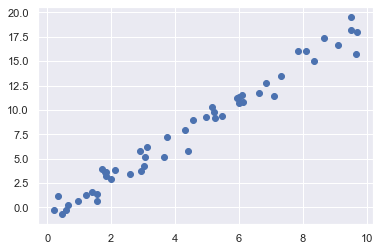

In [5]:
import numpy as np

# rng for Random Number Generator
rng = np.random.RandomState(42)

X = 10 * rng.rand(50)
y = 2 * X - 1 + rng.randn(50)

X = pd.DataFrame(X)
y = pd.Series(y)

plt.scatter(X, y);

How does the custom data generator work?
* Part of the data is supposed to be random, so we need a **random number generator**. I use NumPy's own [`RandomState`](https://numpy.org/doc/stable/reference/random/legacy.html#numpy.random.RandomState) for this, which I *seed* with 42. The same seed will give you the same sequence of random numbers.
    * `RandomState`'s [`rand()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.rand.html) function returns random numbers $\in [0, 1)$.
    * `RandomState`'s [`randn()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.RandomState.randn.html) function returns random numbers $\sim N(0, 1)$
* How to compute the feature matrix `X`:
    * By calling `rand(50)` I get 50 random numbers.
    * I multiply the 50 random numbers by 10 to get random numbers over $[0, 10)$. (This is an example of a *UFunc*.)
    * For simplicity, this data only has one feature (or variable, or column).
* How to compute the outcome vector `y`:
    * I compute the outcome variable `y` as a function of `X` and some random standard-normal $N(0, 1)$ noise (`rng.randn(50)`).
* I wrap both `ndarray`s in the corresponding Pandas `DataFrame` and `Series`.

## Model Training

We follow the `sklearn` training process as seen on the slides.

### 1. Choose a Model

OLS is implemented in `sklearn`'s [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). To be able to use `LinearRegression`, we first need to import it.

In [6]:
from sklearn.linear_model import LinearRegression

### 2. Choose Hyperparameters

*Hyperparameters* determine different modes that models use to fit the data. Think of them as meta-parameters (as opposed to tunable parameters).

Standard OLS comes with one hyperparameter:

- [x] Fit the intercept?

In [7]:
model = LinearRegression(fit_intercept=True)
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

If we print the model to the console we can see its hyperparameter.

### 3. Arrange Data in Feature Matrix and Target Vector
The [`Model.fit(X, y)`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) methods requires data in the following shape:
* `y` needs to be an `n_samples` long vector
* `X` needs to be a `[n_samples, n_features]` matrix

In [8]:
X.shape

(50, 1)

In [9]:
y.shape

(50,)

### 4. Fit the Model to the Data
We fit the following model: $Y = \beta_0 + \beta X + \epsilon$

In [10]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

The fitted $\beta$:

In [11]:
model.coef_

array([1.9776566])

Recall that the true model is $y = 2X - 1 + \epsilon$. Our estimate of $ \beta$ is very close to the true $2$.

The fitted $\beta_0$:

In [12]:
model.intercept_

-0.9033107255311164

Also very close to the true $-1$.

We can plot the regression line (in red) against the data (blue dots):

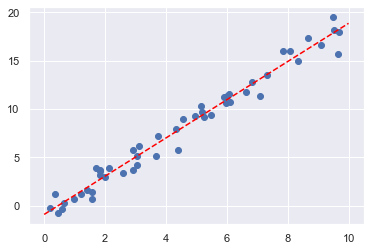

In [13]:
plt.scatter(X, y)
plt.plot([0, 10],
         [0 * model.coef_ + model.intercept_,
          10 * model.coef_ + model.intercept_],
         c='red', linestyle='--');

* The syntax is [`Matplotlib.plot(x, y, format)`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot). For example, `c='red'` colours the line red and `linestyle='--'` makes dashes.
* To plot the red line, we only use two points at $X=0$ and $X=10$:
    * $Y$ at $X=0$ is $Y=0×\beta + \beta_0$
    * $Y$ at $X=10$ is $Y=10×\beta + \beta_0$

The model fits the data fairly well. In addition to this visual evaluation, we can also have a look at OLS's main measure of fit, the $R^2$ score:

In [14]:
model.score(X, y)

0.9749140085676858

## Evaluate Model in Test Data

Let's generate some more data from the same data-generating process, which we will use as test data in this example.

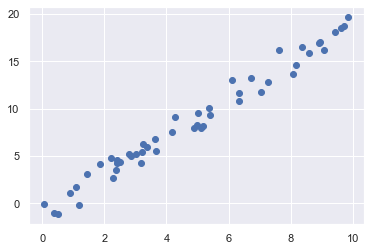

In [15]:
X_test = 10 * rng.rand(50)
y_test = 2 * X_test - 1 + rng.randn(50)

X_test = pd.DataFrame(X_test)
y_test = pd.Series(y_test)

plt.scatter(X_test, y_test);

Of course it looks very similar to our original data, because the data-generating process is the same.

In the homework assignments, you will also get training and test data, and you are asked to predict the outcome variables in the test data. You can do that (after the model is trained) with the model's `predict()` function:

In [16]:
y_pred = model.predict(X_test)

`predict()` takes the feature matrix (in this case, that of the test data, `X_test`) and returns the predicted labels/outcome variables (`y_pred`) based on the estimated parameters.

In [17]:
y_pred

array([16.74844122,  9.76302672, 15.0650828 , 16.81829801,  5.38570599,
        1.27313842,  3.60446406,  7.54341465, 15.27421228, 16.11898447,
       -0.76582146,  9.19751702,  7.35164553,  3.48921905,  1.46721462,
        5.773558  , 17.74420527,  5.48853339,  9.35658625, 12.99999012,
        6.28803411, 18.31520177, 18.13059173,  4.07607847,  8.93055717,
        5.04702903,  4.72985611, -0.17381358, 11.15177856,  9.03795416,
        0.1147622 ,  4.60735947, 17.05906952,  3.83440082,  1.96221228,
        8.77638409, 18.58947054,  3.88371133, 12.38922229, 14.15890987,
        3.79634385, 13.49830796,  6.37017667, 11.60152727, 11.62573141,
        9.69247268,  0.88231087, 15.61610421,  5.4406174 ,  2.78538491])

To evaluate how our OLS model is doing in the test data, we import the $R^2$ scoring function [`r2_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) and pass it the true labels and our predicted ones.

In [18]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.9758813246138494

© 2023 Philipp Cornelius